In [1]:
from google.colab import files

uploaded = files.upload()

Saving archive (6).zip to archive (6).zip
Saving ethereum-historical-data.csv to ethereum-historical-data.csv
Saving solana-historical-data.csv to solana-historical-data.csv
Saving tether-historical-data.csv to tether-historical-data.csv


In [2]:
!unzip archive.zip -d extracted_folder

Archive:  archive.zip
  inflating: extracted_folder/btcusd_1-min_data.csv  


In [3]:
import pandas as pd

bitcoin = pd.read_csv("extracted_folder/btcusd_1-min_data.csv")
ethereum = pd.read_csv("ethereum-historical-data.csv")
solana = pd.read_csv('solana-historical-data.csv')
tether = pd.read_csv('tether-historical-data.csv')

In [4]:
# Переводим колонку Timestamp датасета bitcoin в более привычный формат
bitcoin["Timestamp"] = pd.to_datetime(bitcoin["Timestamp"], unit="s") # unit="s" - значение в секундах с начала эпохи Unix (01.01.1970 00:00:00 UTC)

In [5]:
# Преобразуем дату остальных датасетов в тип datetime, чтобы можно было использовать временные методы
ethereum["Дата"] = pd.to_datetime(ethereum["Дата"])
solana["Дата"] = pd.to_datetime(solana["Дата"])
tether["Дата"] = pd.to_datetime(tether["Дата"])

Приведём все датасеты к единой структуре: для биткоина перейдём от поминутных значений к посуточным.

In [6]:
bitcoin = bitcoin.sort_values("Timestamp")

# Создаём колонку с датой без времени (время всегда будет 00:00:00)
bitcoin["Date"] = bitcoin["Timestamp"].dt.floor("D")  # или .normalize()

# Группируем по дате ("Date" автоматически станет индексом)
bitcoin_daily = bitcoin.groupby("Date").agg({
    "Open": "first",     # первое значение за сутки
    "High": "max",       # максимум за сутки
    "Low": "min",        # минимум за сутки
    "Close": "last",     # последнее значение за сутки
    "Volume": "sum"      # сумма объёмов торгов за сутки
})

In [7]:
# Делаем дату индексом и для других валют
ethereum = ethereum.set_index("Дата")
solana = solana.set_index("Дата")
tether = tether.set_index("Дата")

In [8]:
# Обрезаем записи по биткоину, чтобы все 4 датасета отражали данные за один и тот же промежуток времени
start_date = "2022-06-09"
end_date = "2025-06-09"

bitcoin_filtered = bitcoin_daily.loc[start_date:end_date].copy()

В качестве целевой переменной берём Close.
Что можно использовать в кач-ве признаков, помимо Open, High, Low, Volume:
- лаги,
- скользящие средние,
- индикаторы волатильности,
- технические индикаторы.

In [9]:
# Добавим лаги (я выбрала сдвиги по зову сердца, а вообще можно построить ACF/PACF и выбрать лаги, где корреляция значима)
bitcoin_filtered["Close_lag_1"] = bitcoin_filtered["Close"].shift(1)
bitcoin_filtered["Close_lag_7"] = bitcoin_filtered["Close"].shift(7)
bitcoin_filtered["Close_lag_14"] = bitcoin_filtered["Close"].shift(14)

In [10]:
# Добавим также скользящие средние за 7 и 30 дней (принцип выбора окон - рандом)
bitcoin_filtered["Close_MA_7"] = bitcoin_filtered["Close"].rolling(window=7).mean()
bitcoin_filtered["Close_MA_30"] = bitcoin_filtered["Close"].rolling(window=30).mean()

In [12]:
# Задача - предсказать цену биткоина на следующий день, через неделю и через месяц

bitcoin_filtered["Target_1d"] = bitcoin_filtered["Close"].shift(-1)
bitcoin_filtered["Target_7d"] = bitcoin_filtered["Close"].shift(-7)
bitcoin_filtered["Target_30d"] = bitcoin_filtered["Close"].shift(-30)

bitcoin_model_data = bitcoin_filtered.dropna() # удалим строки с null, которые появились после добавления лагов, скользящих средних и колонок для предикта

In [15]:
bitcoin_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2022-06-09 to 2025-06-09
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1097 non-null   float64
 1   High          1097 non-null   float64
 2   Low           1097 non-null   float64
 3   Close         1097 non-null   float64
 4   Volume        1097 non-null   float64
 5   Close_lag_1   1096 non-null   float64
 6   Close_lag_7   1090 non-null   float64
 7   Close_lag_14  1083 non-null   float64
 8   Close_MA_7    1091 non-null   float64
 9   Close_MA_30   1068 non-null   float64
 10  Target_1d     1096 non-null   float64
 11  Target_7d     1090 non-null   float64
 12  Target_30d    1067 non-null   float64
dtypes: float64(13)
memory usage: 120.0 KB


In [16]:
bitcoin_model_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1038 entries, 2022-07-08 to 2025-05-10
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1038 non-null   float64
 1   High          1038 non-null   float64
 2   Low           1038 non-null   float64
 3   Close         1038 non-null   float64
 4   Volume        1038 non-null   float64
 5   Close_lag_1   1038 non-null   float64
 6   Close_lag_7   1038 non-null   float64
 7   Close_lag_14  1038 non-null   float64
 8   Close_MA_7    1038 non-null   float64
 9   Close_MA_30   1038 non-null   float64
 10  Target_1d     1038 non-null   float64
 11  Target_7d     1038 non-null   float64
 12  Target_30d    1038 non-null   float64
dtypes: float64(13)
memory usage: 113.5 KB


In [17]:
train = bitcoin_model_data.loc[:'2024-12-31']
test = bitcoin_model_data.loc['2025-01-01':]

In [18]:
features = ["Open","High","Low","Close","Volume",
            "Close_lag_1","Close_lag_7","Close_lag_14",
            "Close_MA_7","Close_MA_30"]

X_train = train[features]
y_train_1d = train["Target_1d"]
y_train_7d = train["Target_7d"]
y_train_30d = train["Target_30d"]

X_test = test[features]
y_test_1d = test["Target_1d"]
y_test_7d = test["Target_7d"]
y_test_30d = test["Target_30d"]

In [19]:
from xgboost import XGBRegressor

model_1d = XGBRegressor(
    n_estimators=500, # число деревьев в ансамбле
    learning_rate=0.05,
    max_depth=5, # максимальная глубина каждого дерева
    subsample=0.8, # доля строк, случайно выбираемых для каждого дерева
    colsample_bytree=0.8, # доля признаков на уровне дерева
    random_state=42 # фиксируем случайность для воспроизводимости результатов
)
model_1d.fit(X_train, y_train_1d)

pred_1d = model_1d.predict(X_test)

In [20]:
# Оценка качества
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_1d, pred_1d)
rmse = np.sqrt(mean_squared_error(y_test_1d, pred_1d))

print("MAE:", mae, "RMSE:", rmse)

MAE: 3318.7819711538464 RMSE: 4169.614661093797


In [21]:
bitcoin_model_data.head(10)

,Open,High,Low,Close,Volume,Close_lag_1,Close_lag_7,Close_lag_14,Close_MA_7,Close_MA_30,Target_1d,Target_7d,Target_30d
Date,,,,,,,,,,,,,
2022-07-08,21845.00,22401.00,21164.07,21786.43,3424.440709,21835.16,19359.05,21233.64,20403.722857,21641.642000,21618.77,21159.36,23163.32
2022-07-09,21788.09,22013.04,21311.36,21618.77,1092.811345,21786.43,19246.22,21194.44,20742.658571,21362.571667,20918.25,21182.79,23933.95
2022-07-10,21607.28,21739.83,20629.99,20918.25,1226.649757,21618.77,19480.60,21277.60,20948.037143,21095.278333,20491.63,21030.89,23072.86
2022-07-11,20910.32,21170.42,20251.72,20491.63,1362.608710,20918.25,19803.63,20829.08,21046.322857,20825.965000,19382.50,21615.00,23646.00
2022-07-12,20477.40,20541.44,19274.88,19382.50,1870.146623,20491.63,20378.70,20238.96,20904.008571,20559.140667,19645.03,23409.44,24240.00
2022-07-13,19381.59,20102.05,18905.55,19645.03,2830.143795,19382.50,20295.32,20201.96,20811.110000,20442.505667,20578.79,23673.67,24194.00
2022-07-14,19645.03,20880.00,19577.91,20578.79,2957.393963,19645.03,21835.16,18901.60,20631.628571,20389.806000,21159.36,23210.61,24418.00
2022-07-15,20608.68,21164.65,20368.70,21159.36,1535.893861,20578.79,21786.43,19359.05,20542.047143,20375.364667,21182.79,22591.06,24292.00
2022-07-16,21161.63,21577.00,20472.68,21182.79,1652.285723,21159.36,21618.77,19246.22,20479.764286,20386.500000,21030.89,22281.94,23982.00


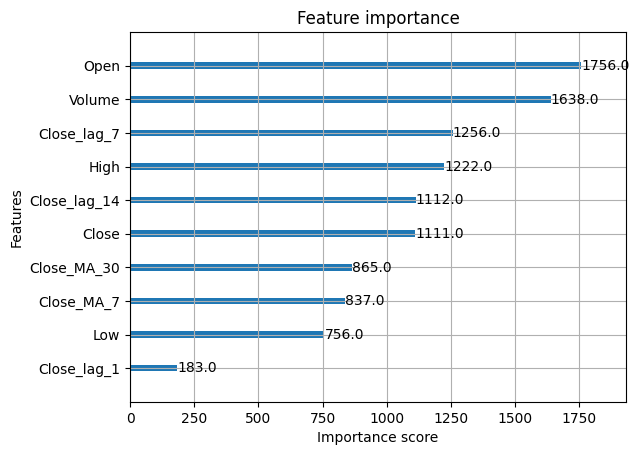

In [22]:
# Важность признаков
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model_1d)
plt.show()

To-do list:
- поподбирать параметры для модели,
- попробовать различные комбинации фичей,
- использовать и другие датасеты (корреляция валют),
- другие модели,
- иная предобработка (?),
- проделать всё это для трёх остальных валют.

https://github.com/Leta1603/ML04/blob/main/Homework%2028/homework.ipynb - корреляция рядов by Виолетта
https://github.com/MariaEgorenko/courses_ml/tree/l28/lesson28 - отставания by Маша
